# Working with parquet files

## Objective

+ In this assignment, we will use the data downloaded with the module `data_manager` to create features.

(11 pts total)

## Prerequisites

+ This notebook assumes that price data is available to you in the environment variable `PRICE_DATA`. If you have not done so, then execute the notebook `01_materials/labs/2_data_engineering.ipynb` to create this data set.


In [1]:
#for Logging
import sys
sys.path.append("../../05_src")
from logger import get_logger

_logs = get_logger(__name__)

# Function to enable/disable logging
enable_log=False
def log_info(message):
    """Logs an info message if enable_log is True."""
    
    if enable_log:
        _logs.info(message)

log_info("Assignment 1 Begins!")

+ Load the environment variables using dotenv. (1 pt)

In [2]:
from dotenv import load_dotenv
# Provided the correct path, for load_dotenv to traverse and load the existing .env file, from the Materials labs folder
load_dotenv('../../01_materials/labs/.env')

#log env path
log_info(f'.env path set to "../../01_materials/labs/.env"')

In [3]:
import dask.dataframe as dd


f:\ProgramData\miniconda3\envs\dsi_participant\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
C:\Users\charles\AppData\Local\Temp\ipykernel_65248\2893826485.py:1: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can

+ Load the environment variable `PRICE_DATA`.
+ Use [glob](https://docs.python.org/3/library/glob.html) to find the path of all parquet files in the directory `PRICE_DATA`.

(1pt)

In [4]:
import os
from glob import glob

#read the path of the PRICE_DATA parquet files form the environment variable
PRICE_DATA = os.getenv("PRICE_DATA")

print(f'\n Parquet files for PRICE DATA are stored at: {PRICE_DATA}')


#perform file search, matching pattern using the glob function and store into a list
parquet_files = glob(os.path.join(PRICE_DATA, "*/*/*.parquet"))


# Check if any files were found and log the appropriate message
if parquet_files:
    log_info(f'Found {len(parquet_files)} parquet files.')
else:
    log_info('No parquet files were found in the specified directory.')


print(f'\n Total Parquet Files: {len(parquet_files)}')
print(f'*********************************')
print(f"Preview of the first 5 file paths")
print(f'*********************************')
for parquet_file in parquet_files[:5]:
    print(f"{parquet_file}")



 Parquet files for PRICE DATA are stored at: ../../05_src/data/prices/

 Total Parquet Files: 11207
*********************************
Preview of the first 5 file paths
*********************************
../../05_src/data/prices\A\A_2000.parquet\part.0.parquet
../../05_src/data/prices\A\A_2001.parquet\part.0.parquet
../../05_src/data/prices\A\A_2002.parquet\part.0.parquet
../../05_src/data/prices\A\A_2003.parquet\part.0.parquet
../../05_src/data/prices\A\A_2004.parquet\part.0.parquet


For each ticker and using Dask, do the following:

+ Add lags for variables Close and Adj_Close.
+ Add returns based on Adjusted Close:
    
    - `returns`: (Adj Close / Adj Close_lag) - 1

+ Add the following range: 

    - `hi_lo_range`: this is the day's High minus Low.

+ Assign the result to `dd_feat`.

(4 pt)

In [5]:
#Create a Dask dataframe with the Parquet files
dd_px = dd.read_parquet(parquet_files)


print(f'Dask data frame "dd_px" created: {type(dd_px)}')
rows = dd_px.shape[0].compute()
cols= dd_px.shape[1]
print(f'\n*********************************')
print(f'Shape of dd_px: \nROWS: {rows}  |  COLUMNS: {cols}')
print(f'*********************************')
log_info(f'Dask data frame "dd_px" created: {type(dd_px)} with {rows} rows & {cols} columns')



# Creating Dask data frame dd_feat with calculated columns, Close_Lag, Adj_Close_Lag, returns and hi_lo_range

dd_feat = (
    dd_px.groupby('ticker', group_keys=False)
    .apply(lambda x: x.assign(
        Close_lag=x['Close'].shift(1),
        Adj_Close_lag=x['Adj Close'].shift(1),
        returns=(x['Adj Close'] / x['Adj Close'].shift(1)) - 1,
        hi_lo_range=x['High'] - x['Low']
    ))
)

print(f'\nDask data frame "dd_feat" created: {type(dd_px)}')
log_info(f'Dask data frame "dd_feat" created with Columns: Close_Lag, Adj_Close_Lag, returns and hi_lo_range')

print(f'\n*************************************')
print(f'Preview of Dask data frame "dd_feat"')
print(f'*************************************')
dd_feat.compute()

Dask data frame "dd_px" created: <class 'dask.dataframe.core.DataFrame'>

*********************************
Shape of dd_px: 
ROWS: 2779193  |  COLUMNS: 10
*********************************

Dask data frame "dd_feat" created: <class 'dask.dataframe.core.DataFrame'>

*************************************
Preview of Dask data frame "dd_feat"
*************************************


C:\Users\charles\AppData\Local\Temp\ipykernel_65248\2089759421.py:18: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  dd_px.groupby('ticker', group_keys=False)


,Date,Open,High,Low,Close,Adj Close,Volume,sector,subsector,year,Close_lag,Adj_Close_lag,returns,hi_lo_range
ticker,,,,,,,,,,,,,,
HUM,2021-01-04,417.820007,417.989990,400.489990,412.190002,400.628448,1268200,Health Care,Managed Health Care,2021,NaN,NaN,NaN,17.500000
HUM,2021-01-05,408.920013,417.010010,408.920013,413.179993,401.590759,958400,Health Care,Managed Health Care,2021,412.190002,400.628448,0.002402,8.089996
HUM,2021-01-06,405.600006,438.070007,405.500000,437.829987,425.549225,1495200,Health Care,Managed Health Care,2021,413.179993,401.590759,0.059659,32.570007
HUM,2021-01-07,437.019989,449.279999,435.500000,447.690002,435.132690,1421400,Health Care,Managed Health Care,2021,437.829987,425.549225,0.022520,13.779999
HUM,2021-01-08,446.510010,448.000000,432.220001,436.769989,424.518951,962500,Health Care,Managed Health Care,2021,447.690002,435.132690,-0.024392,15.779999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JNPR,2019-12-24,24.510000,24.510000,24.270000,24.290001,21.141632,714900,Information Technology,Communications Equipment,2019,24.469999,21.298298,-0.007356,0.240000
JNPR,2019-12-26,24.290001,24.530001,24.290001,24.490000,21.315708,1141000,Information Technology,Communications Equipment,2019,24.290001,21.141632,0.008234,0.240000
JNPR,2019-12-27,24.570000,24.610001,24.389999,24.410000,21.246075,3030300,Information Technology,Communications Equipment,2019,24.490000,21.315708,-0.003267,0.220001


+ Convert the Dask data frame to a pandas data frame. 
+ Add a rolling average return calculation with a window of 10 days.
+ *Tip*: Consider using `.rolling(10).mean()`.

(3 pt)

In [6]:
#Convert the Dask data frame to a Pandas data frame
pd_feat = dd_feat.compute()

print(f'Pandas data frame "pd_feat" created: {type(pd_feat)}')
log_info(f'Pandas data frame "pd_feat" created from Dask data frame "dd_feat"')




#Add rolling_avg_return column 
pd_feat = (pd_feat.groupby('ticker', group_keys=False).apply(
    lambda x: x.assign(rolling_avg_return = x['returns'].rolling(10).mean())
))


log_info(f'column "rolling_avg_return" added to Pandas data frame "pd_feat"')
log_info(f'End of Assignment 1!')

print(f'\n***************************************')
print(f'Preview of Pandas data frame "pd_feat"')
print(f'***************************************')

pd_feat

Pandas data frame "pd_feat" created: <class 'pandas.core.frame.DataFrame'>

***************************************
Preview of Pandas data frame "pd_feat"
***************************************


,Date,Open,High,Low,Close,Adj Close,Volume,sector,subsector,year,Close_lag,Adj_Close_lag,returns,hi_lo_range,rolling_avg_return
ticker,,,,,,,,,,,,,,,
HUM,2021-01-04,417.820007,417.989990,400.489990,412.190002,400.628448,1268200,Health Care,Managed Health Care,2021,NaN,NaN,NaN,17.500000,NaN
HUM,2021-01-05,408.920013,417.010010,408.920013,413.179993,401.590759,958400,Health Care,Managed Health Care,2021,412.190002,400.628448,0.002402,8.089996,NaN
HUM,2021-01-06,405.600006,438.070007,405.500000,437.829987,425.549225,1495200,Health Care,Managed Health Care,2021,413.179993,401.590759,0.059659,32.570007,NaN
HUM,2021-01-07,437.019989,449.279999,435.500000,447.690002,435.132690,1421400,Health Care,Managed Health Care,2021,437.829987,425.549225,0.022520,13.779999,NaN
HUM,2021-01-08,446.510010,448.000000,432.220001,436.769989,424.518951,962500,Health Care,Managed Health Care,2021,447.690002,435.132690,-0.024392,15.779999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JNPR,2019-12-24,24.510000,24.510000,24.270000,24.290001,21.141632,714900,Information Technology,Communications Equipment,2019,24.469999,21.298298,-0.007356,0.240000,0.002319
JNPR,2019-12-26,24.290001,24.530001,24.290001,24.490000,21.315708,1141000,Information Technology,Communications Equipment,2019,24.290001,21.141632,0.008234,0.240000,0.002005
JNPR,2019-12-27,24.570000,24.610001,24.389999,24.410000,21.246075,3030300,Information Technology,Communications Equipment,2019,24.490000,21.315708,-0.003267,0.220001,0.000262


Please comment:

### Was it necessary to convert to Pandas to calculate the moving average return?
<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">
- <strong>Not strictly necessary</strong>, but practical. Dask provides a way to calculate rolling averages; however, the syntax and implementation can be more complex compared to Pandas. In this case, we opted to convert to Pandas to leverage its straightforward <code>rolling</code> functionality, which allows for quick and efficient calculations on smaller datasets. This conversion simplifies the code and makes it easier to understand and maintain.
</div>

### Would it have been better to do it in Dask? Why?
<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">
- <strong>Yes, it could have been better to perform the rolling calculation in Dask</strong>, especially if working with larger datasets that exceed memory limits. Dask is designed for parallel computing and can handle larger-than-memory computations efficiently. By using Dask's rolling capabilities, you can maintain the benefits of lazy evaluation and scale your computations without running into memory issues. 

While Dask's rolling functionality may be slightly less intuitive than Pandas', it is still powerful for processing large datasets. Therefore, if scalability and performance with larger datasets are priorities, staying within the Dask framework would be advantageous.
</div>


(1 pt)

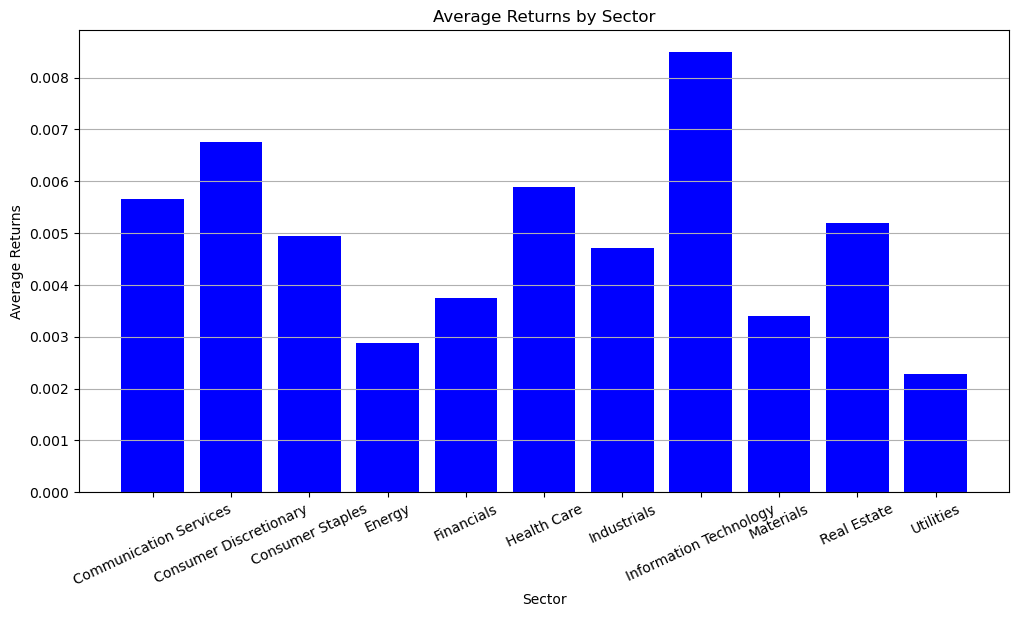

In [7]:
import matplotlib.pyplot as plt

average_returns_by_sector = pd_feat.groupby('sector')['returns'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(average_returns_by_sector['sector'], average_returns_by_sector['returns'], color='blue')
plt.title('Average Returns by Sector')
plt.xticks(rotation=25)
plt.ylabel('Average Returns')
plt.xlabel('Sector')
plt.grid(axis='y') 
plt.show()

Log File Output:

![](./images/assignment1Log.png)


## Criteria

The [rubric](./assignment_1_rubric_clean.xlsx) contains the criteria for grading.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.